# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:09<00:00, 6.33KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

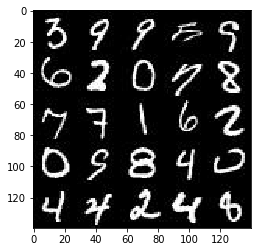

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

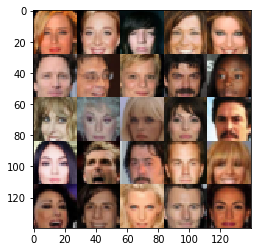

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
#         input 28x28x?
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(x1, alpha * alpha)
#         14x14x64

        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, alpha * x2)
#         7x7x128

        x3 = tf.layers.conv2d(x2, 256, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, alpha * x3)
#         7x7x256 

        x4 = tf.layers.conv2d(x3, 512, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(x4, alpha * x4)
#         7x7x512 

        flat = tf.reshape(x4, (-1, 7 * 7 * 512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7 * 7 * 512, activation=None)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1, alpha * x1)
#         7x7x512

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2, alpha * x2)
#         7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3, alpha * x3)
#         14x14x128

        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(x4, alpha * x4)
#         28x28x64

#         28x28x out_channel_dim
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,  data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.1104... Generator Loss: 12.8246
Epoch 1/2... Discriminator Loss: 0.9917... Generator Loss: 1.0712
Epoch 1/2... Discriminator Loss: 2.6852... Generator Loss: 14.5328
Epoch 1/2... Discriminator Loss: 0.8919... Generator Loss: 4.9776
Epoch 1/2... Discriminator Loss: 0.9321... Generator Loss: 6.9244
Epoch 1/2... Discriminator Loss: 0.5410... Generator Loss: 13.3371
Epoch 1/2... Discriminator Loss: 0.3784... Generator Loss: 8.6944
Epoch 1/2... Discriminator Loss: 0.3509... Generator Loss: 7.0309
Epoch 1/2... Discriminator Loss: 0.3556... Generator Loss: 5.8885
Epoch 1/2... Discriminator Loss: 0.3663... Generator Loss: 4.4319


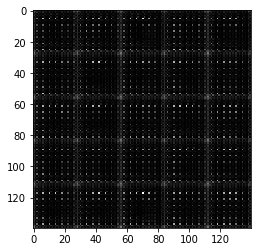

Epoch 1/2... Discriminator Loss: 0.4064... Generator Loss: 6.9434
Epoch 1/2... Discriminator Loss: 0.4963... Generator Loss: 3.1884
Epoch 1/2... Discriminator Loss: 4.7289... Generator Loss: 0.0681
Epoch 1/2... Discriminator Loss: 0.4489... Generator Loss: 5.1028
Epoch 1/2... Discriminator Loss: 8.0153... Generator Loss: 18.1541
Epoch 1/2... Discriminator Loss: 0.4833... Generator Loss: 3.5369
Epoch 1/2... Discriminator Loss: 0.5902... Generator Loss: 2.5581
Epoch 1/2... Discriminator Loss: 0.4646... Generator Loss: 5.0125
Epoch 1/2... Discriminator Loss: 1.4816... Generator Loss: 2.3896
Epoch 1/2... Discriminator Loss: 0.9453... Generator Loss: 3.5265


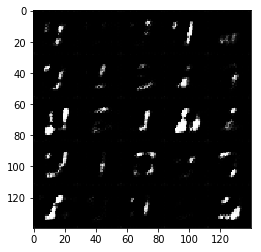

Epoch 1/2... Discriminator Loss: 0.6464... Generator Loss: 3.9525
Epoch 1/2... Discriminator Loss: 4.5863... Generator Loss: 0.0985
Epoch 1/2... Discriminator Loss: 0.5476... Generator Loss: 3.1706
Epoch 1/2... Discriminator Loss: 0.7755... Generator Loss: 1.9529
Epoch 1/2... Discriminator Loss: 0.4440... Generator Loss: 3.1137
Epoch 1/2... Discriminator Loss: 1.2817... Generator Loss: 1.4864
Epoch 1/2... Discriminator Loss: 0.5124... Generator Loss: 6.6695
Epoch 1/2... Discriminator Loss: 0.8122... Generator Loss: 5.5813
Epoch 1/2... Discriminator Loss: 0.4648... Generator Loss: 3.4663
Epoch 1/2... Discriminator Loss: 0.6211... Generator Loss: 2.3967


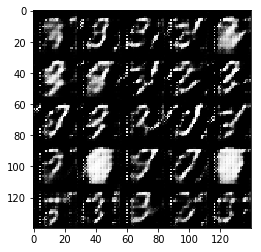

Epoch 1/2... Discriminator Loss: 0.4688... Generator Loss: 2.8161
Epoch 1/2... Discriminator Loss: 0.4270... Generator Loss: 2.7272
Epoch 1/2... Discriminator Loss: 0.3711... Generator Loss: 4.2106
Epoch 1/2... Discriminator Loss: 0.3727... Generator Loss: 3.9863
Epoch 1/2... Discriminator Loss: 0.3888... Generator Loss: 5.5221
Epoch 1/2... Discriminator Loss: 0.3775... Generator Loss: 3.7707
Epoch 1/2... Discriminator Loss: 0.3596... Generator Loss: 4.8081
Epoch 1/2... Discriminator Loss: 0.5463... Generator Loss: 2.8139
Epoch 1/2... Discriminator Loss: 0.3743... Generator Loss: 4.5142
Epoch 1/2... Discriminator Loss: 0.5100... Generator Loss: 7.9255


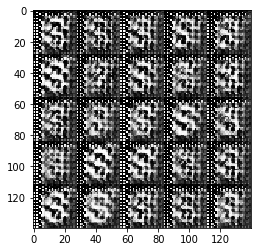

Epoch 1/2... Discriminator Loss: 4.2148... Generator Loss: 0.3439
Epoch 1/2... Discriminator Loss: 0.6779... Generator Loss: 5.0067
Epoch 1/2... Discriminator Loss: 0.5177... Generator Loss: 2.8643
Epoch 1/2... Discriminator Loss: 1.6585... Generator Loss: 0.6857
Epoch 1/2... Discriminator Loss: 0.7457... Generator Loss: 2.3044
Epoch 1/2... Discriminator Loss: 0.4066... Generator Loss: 3.8188
Epoch 2/2... Discriminator Loss: 1.8462... Generator Loss: 1.0196
Epoch 2/2... Discriminator Loss: 1.8896... Generator Loss: 4.3766
Epoch 2/2... Discriminator Loss: 0.5141... Generator Loss: 2.3194
Epoch 2/2... Discriminator Loss: 0.8520... Generator Loss: 5.9447


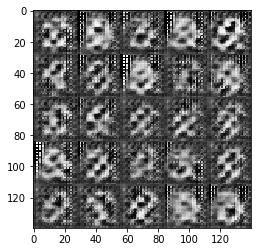

Epoch 2/2... Discriminator Loss: 0.4729... Generator Loss: 3.9601
Epoch 2/2... Discriminator Loss: 0.5857... Generator Loss: 5.4258
Epoch 2/2... Discriminator Loss: 0.5172... Generator Loss: 3.8684
Epoch 2/2... Discriminator Loss: 1.0056... Generator Loss: 2.0872
Epoch 2/2... Discriminator Loss: 0.8462... Generator Loss: 2.0973
Epoch 2/2... Discriminator Loss: 2.2483... Generator Loss: 0.5475
Epoch 2/2... Discriminator Loss: 1.8508... Generator Loss: 1.3606
Epoch 2/2... Discriminator Loss: 1.5300... Generator Loss: 0.6550
Epoch 2/2... Discriminator Loss: 0.7620... Generator Loss: 4.5423
Epoch 2/2... Discriminator Loss: 1.2909... Generator Loss: 0.8184


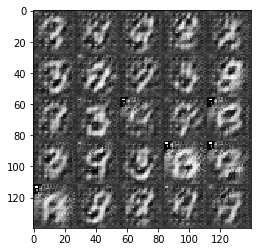

Epoch 2/2... Discriminator Loss: 0.7303... Generator Loss: 2.4037
Epoch 2/2... Discriminator Loss: 1.1159... Generator Loss: 1.5806
Epoch 2/2... Discriminator Loss: 1.8972... Generator Loss: 0.8095
Epoch 2/2... Discriminator Loss: 0.8913... Generator Loss: 1.3772
Epoch 2/2... Discriminator Loss: 0.5736... Generator Loss: 2.3876
Epoch 2/2... Discriminator Loss: 0.3594... Generator Loss: 6.1643
Epoch 2/2... Discriminator Loss: 0.4067... Generator Loss: 4.0362
Epoch 2/2... Discriminator Loss: 0.4631... Generator Loss: 2.8767
Epoch 2/2... Discriminator Loss: 0.4949... Generator Loss: 3.0581
Epoch 2/2... Discriminator Loss: 0.7159... Generator Loss: 1.9714


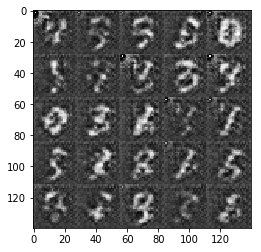

Epoch 2/2... Discriminator Loss: 1.3373... Generator Loss: 0.6953
Epoch 2/2... Discriminator Loss: 0.6504... Generator Loss: 1.6275
Epoch 2/2... Discriminator Loss: 1.3743... Generator Loss: 3.7087
Epoch 2/2... Discriminator Loss: 1.9000... Generator Loss: 4.4541
Epoch 2/2... Discriminator Loss: 1.0118... Generator Loss: 2.3004
Epoch 2/2... Discriminator Loss: 0.8769... Generator Loss: 4.8603
Epoch 2/2... Discriminator Loss: 0.6627... Generator Loss: 1.5585
Epoch 2/2... Discriminator Loss: 0.4134... Generator Loss: 3.6529
Epoch 2/2... Discriminator Loss: 0.7605... Generator Loss: 1.4161
Epoch 2/2... Discriminator Loss: 0.5263... Generator Loss: 4.4029


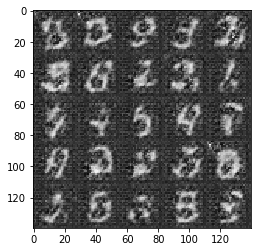

Epoch 2/2... Discriminator Loss: 1.0405... Generator Loss: 1.7206
Epoch 2/2... Discriminator Loss: 0.7582... Generator Loss: 1.3561
Epoch 2/2... Discriminator Loss: 0.4081... Generator Loss: 5.2752
Epoch 2/2... Discriminator Loss: 1.5768... Generator Loss: 2.7318
Epoch 2/2... Discriminator Loss: 0.6818... Generator Loss: 1.8098
Epoch 2/2... Discriminator Loss: 0.5357... Generator Loss: 4.6035
Epoch 2/2... Discriminator Loss: 0.3893... Generator Loss: 4.2012
Epoch 2/2... Discriminator Loss: 0.7681... Generator Loss: 1.4348
Epoch 2/2... Discriminator Loss: 2.2232... Generator Loss: 0.4033
Epoch 2/2... Discriminator Loss: 0.5550... Generator Loss: 4.1191


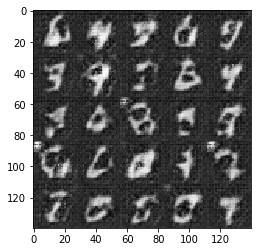

Epoch 2/2... Discriminator Loss: 0.7305... Generator Loss: 1.2498
Epoch 2/2... Discriminator Loss: 0.3925... Generator Loss: 5.0561
Epoch 2/2... Discriminator Loss: 0.3617... Generator Loss: 4.7405


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7927... Generator Loss: 8.9663
Epoch 1/1... Discriminator Loss: 2.2708... Generator Loss: 1.9551
Epoch 1/1... Discriminator Loss: 2.5469... Generator Loss: 0.2557
Epoch 1/1... Discriminator Loss: 2.7197... Generator Loss: 0.2438
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 1.6438
Epoch 1/1... Discriminator Loss: 0.6065... Generator Loss: 2.1404
Epoch 1/1... Discriminator Loss: 0.6595... Generator Loss: 3.2823
Epoch 1/1... Discriminator Loss: 0.4452... Generator Loss: 3.1161
Epoch 1/1... Discriminator Loss: 0.5343... Generator Loss: 3.4499
Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 1.3004


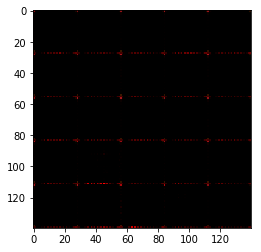

Epoch 1/1... Discriminator Loss: 0.9801... Generator Loss: 1.1662
Epoch 1/1... Discriminator Loss: 0.7591... Generator Loss: 1.3634
Epoch 1/1... Discriminator Loss: 0.5257... Generator Loss: 4.1238
Epoch 1/1... Discriminator Loss: 0.4026... Generator Loss: 3.0954
Epoch 1/1... Discriminator Loss: 0.3829... Generator Loss: 4.4578
Epoch 1/1... Discriminator Loss: 0.3712... Generator Loss: 3.9675
Epoch 1/1... Discriminator Loss: 0.4222... Generator Loss: 4.8047
Epoch 1/1... Discriminator Loss: 0.4388... Generator Loss: 3.3868
Epoch 1/1... Discriminator Loss: 0.6362... Generator Loss: 4.2810
Epoch 1/1... Discriminator Loss: 0.4571... Generator Loss: 3.3402


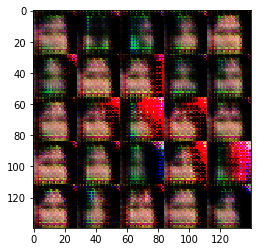

Epoch 1/1... Discriminator Loss: 0.5257... Generator Loss: 3.0305
Epoch 1/1... Discriminator Loss: 0.4547... Generator Loss: 2.5670
Epoch 1/1... Discriminator Loss: 0.3755... Generator Loss: 5.2113
Epoch 1/1... Discriminator Loss: 0.3680... Generator Loss: 3.9088
Epoch 1/1... Discriminator Loss: 0.4127... Generator Loss: 3.7957
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.1145
Epoch 1/1... Discriminator Loss: 0.5287... Generator Loss: 2.0786
Epoch 1/1... Discriminator Loss: 0.3585... Generator Loss: 3.9982
Epoch 1/1... Discriminator Loss: 0.4817... Generator Loss: 2.8268
Epoch 1/1... Discriminator Loss: 0.3628... Generator Loss: 4.5621


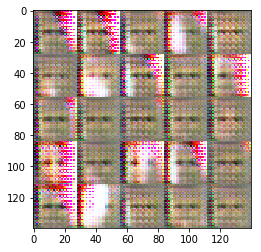

Epoch 1/1... Discriminator Loss: 0.4172... Generator Loss: 3.9275
Epoch 1/1... Discriminator Loss: 0.4301... Generator Loss: 2.6502
Epoch 1/1... Discriminator Loss: 0.3585... Generator Loss: 3.8431
Epoch 1/1... Discriminator Loss: 0.3445... Generator Loss: 10.3736
Epoch 1/1... Discriminator Loss: 0.3827... Generator Loss: 3.9933
Epoch 1/1... Discriminator Loss: 0.3331... Generator Loss: 8.7445
Epoch 1/1... Discriminator Loss: 0.3421... Generator Loss: 6.8214
Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 3.9000
Epoch 1/1... Discriminator Loss: 0.4067... Generator Loss: 3.0655
Epoch 1/1... Discriminator Loss: 0.3804... Generator Loss: 3.2918


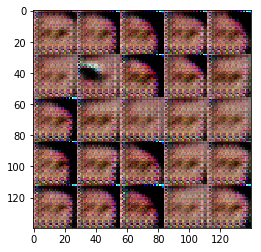

Epoch 1/1... Discriminator Loss: 8.2614... Generator Loss: 9.0150
Epoch 1/1... Discriminator Loss: 0.5960... Generator Loss: 2.4265
Epoch 1/1... Discriminator Loss: 0.3806... Generator Loss: 3.5959
Epoch 1/1... Discriminator Loss: 0.5238... Generator Loss: 2.5841
Epoch 1/1... Discriminator Loss: 3.7295... Generator Loss: 1.2365
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 3.1264
Epoch 1/1... Discriminator Loss: 0.8297... Generator Loss: 1.5196
Epoch 1/1... Discriminator Loss: 1.6647... Generator Loss: 1.8841
Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 1.7760
Epoch 1/1... Discriminator Loss: 0.8729... Generator Loss: 1.5489


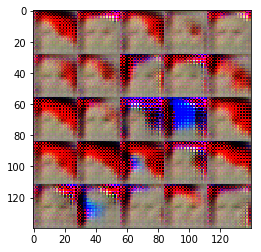

Epoch 1/1... Discriminator Loss: 0.4712... Generator Loss: 3.1277
Epoch 1/1... Discriminator Loss: 0.4982... Generator Loss: 3.0026
Epoch 1/1... Discriminator Loss: 0.4382... Generator Loss: 3.7462
Epoch 1/1... Discriminator Loss: 0.4901... Generator Loss: 2.5205
Epoch 1/1... Discriminator Loss: 0.3585... Generator Loss: 7.2802
Epoch 1/1... Discriminator Loss: 0.4292... Generator Loss: 3.1275
Epoch 1/1... Discriminator Loss: 0.5589... Generator Loss: 2.8220
Epoch 1/1... Discriminator Loss: 0.3620... Generator Loss: 5.8215
Epoch 1/1... Discriminator Loss: 0.4255... Generator Loss: 3.1091
Epoch 1/1... Discriminator Loss: 0.4093... Generator Loss: 3.2500


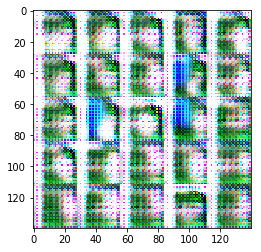

Epoch 1/1... Discriminator Loss: 0.3898... Generator Loss: 3.4025
Epoch 1/1... Discriminator Loss: 0.3707... Generator Loss: 6.3540
Epoch 1/1... Discriminator Loss: 0.3650... Generator Loss: 3.8837
Epoch 1/1... Discriminator Loss: 0.3727... Generator Loss: 4.3747
Epoch 1/1... Discriminator Loss: 0.3532... Generator Loss: 6.3181
Epoch 1/1... Discriminator Loss: 0.4406... Generator Loss: 3.8699
Epoch 1/1... Discriminator Loss: 0.4480... Generator Loss: 2.7354
Epoch 1/1... Discriminator Loss: 0.4563... Generator Loss: 2.7185
Epoch 1/1... Discriminator Loss: 0.3841... Generator Loss: 3.7366
Epoch 1/1... Discriminator Loss: 0.4124... Generator Loss: 3.3191


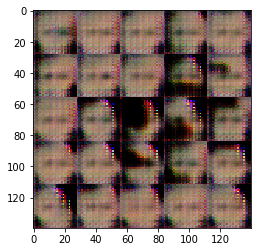

Epoch 1/1... Discriminator Loss: 0.3429... Generator Loss: 5.7364
Epoch 1/1... Discriminator Loss: 0.3683... Generator Loss: 5.4445
Epoch 1/1... Discriminator Loss: 0.4613... Generator Loss: 3.3305
Epoch 1/1... Discriminator Loss: 0.3716... Generator Loss: 3.7276
Epoch 1/1... Discriminator Loss: 0.4663... Generator Loss: 3.4361
Epoch 1/1... Discriminator Loss: 0.4454... Generator Loss: 2.8682
Epoch 1/1... Discriminator Loss: 0.4887... Generator Loss: 2.8370
Epoch 1/1... Discriminator Loss: 3.1825... Generator Loss: 0.1616
Epoch 1/1... Discriminator Loss: 0.5164... Generator Loss: 3.3358
Epoch 1/1... Discriminator Loss: 0.3769... Generator Loss: 3.8647


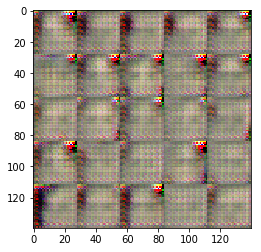

Epoch 1/1... Discriminator Loss: 0.3633... Generator Loss: 3.9049
Epoch 1/1... Discriminator Loss: 0.3715... Generator Loss: 4.8156
Epoch 1/1... Discriminator Loss: 0.6372... Generator Loss: 5.3408
Epoch 1/1... Discriminator Loss: 0.3550... Generator Loss: 5.2529
Epoch 1/1... Discriminator Loss: 0.3475... Generator Loss: 4.9948
Epoch 1/1... Discriminator Loss: 0.3789... Generator Loss: 3.5460
Epoch 1/1... Discriminator Loss: 0.3438... Generator Loss: 8.8059
Epoch 1/1... Discriminator Loss: 0.3552... Generator Loss: 6.8178
Epoch 1/1... Discriminator Loss: 0.3573... Generator Loss: 4.6635
Epoch 1/1... Discriminator Loss: 0.3475... Generator Loss: 5.0279


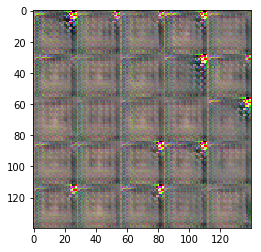

Epoch 1/1... Discriminator Loss: 0.4375... Generator Loss: 2.8832
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 3.1018
Epoch 1/1... Discriminator Loss: 0.4698... Generator Loss: 4.1179
Epoch 1/1... Discriminator Loss: 0.3797... Generator Loss: 3.8283
Epoch 1/1... Discriminator Loss: 0.4427... Generator Loss: 4.3231
Epoch 1/1... Discriminator Loss: 0.3891... Generator Loss: 4.0739
Epoch 1/1... Discriminator Loss: 1.7805... Generator Loss: 6.5065
Epoch 1/1... Discriminator Loss: 0.4039... Generator Loss: 4.5946
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 1.3218


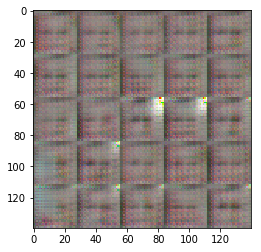

Epoch 1/1... Discriminator Loss: 0.3878... Generator Loss: 8.9844
Epoch 1/1... Discriminator Loss: 0.3687... Generator Loss: 8.2733
Epoch 1/1... Discriminator Loss: 0.3811... Generator Loss: 3.2418
Epoch 1/1... Discriminator Loss: 0.3655... Generator Loss: 4.5107
Epoch 1/1... Discriminator Loss: 0.4281... Generator Loss: 2.5643
Epoch 1/1... Discriminator Loss: 1.7787... Generator Loss: 3.4115
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 1.4368
Epoch 1/1... Discriminator Loss: 0.5526... Generator Loss: 2.2964
Epoch 1/1... Discriminator Loss: 0.5295... Generator Loss: 2.2915
Epoch 1/1... Discriminator Loss: 0.4679... Generator Loss: 2.7032


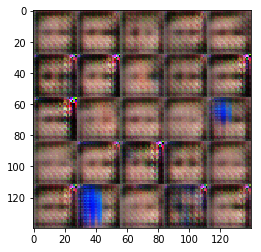

Epoch 1/1... Discriminator Loss: 0.4100... Generator Loss: 3.4115
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 1.0943
Epoch 1/1... Discriminator Loss: 0.3691... Generator Loss: 7.6914
Epoch 1/1... Discriminator Loss: 0.4265... Generator Loss: 3.1216
Epoch 1/1... Discriminator Loss: 0.4101... Generator Loss: 6.4743
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 2.8312
Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 1.3533
Epoch 1/1... Discriminator Loss: 0.4349... Generator Loss: 3.0068
Epoch 1/1... Discriminator Loss: 0.8298... Generator Loss: 1.2514
Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 1.2801


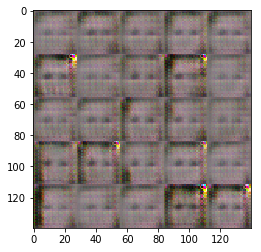

Epoch 1/1... Discriminator Loss: 0.5275... Generator Loss: 2.1212
Epoch 1/1... Discriminator Loss: 0.7248... Generator Loss: 1.4831
Epoch 1/1... Discriminator Loss: 0.3676... Generator Loss: 4.5893
Epoch 1/1... Discriminator Loss: 0.4557... Generator Loss: 3.1162
Epoch 1/1... Discriminator Loss: 0.5513... Generator Loss: 3.3857
Epoch 1/1... Discriminator Loss: 0.3982... Generator Loss: 8.0771
Epoch 1/1... Discriminator Loss: 0.3867... Generator Loss: 7.2114
Epoch 1/1... Discriminator Loss: 0.3700... Generator Loss: 4.9879
Epoch 1/1... Discriminator Loss: 0.5459... Generator Loss: 8.3229
Epoch 1/1... Discriminator Loss: 0.4102... Generator Loss: 3.8705


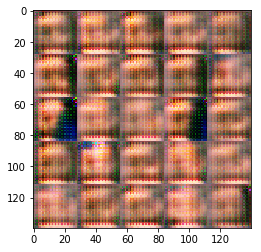

Epoch 1/1... Discriminator Loss: 0.4546... Generator Loss: 3.7559
Epoch 1/1... Discriminator Loss: 0.4645... Generator Loss: 3.6075
Epoch 1/1... Discriminator Loss: 0.5024... Generator Loss: 2.4806
Epoch 1/1... Discriminator Loss: 0.5238... Generator Loss: 2.4913
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 0.5093... Generator Loss: 7.0733
Epoch 1/1... Discriminator Loss: 0.4544... Generator Loss: 3.9958
Epoch 1/1... Discriminator Loss: 0.4266... Generator Loss: 3.6019
Epoch 1/1... Discriminator Loss: 0.5302... Generator Loss: 2.5625
Epoch 1/1... Discriminator Loss: 0.3527... Generator Loss: 6.0765


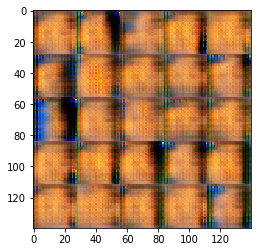

Epoch 1/1... Discriminator Loss: 0.3499... Generator Loss: 5.3782
Epoch 1/1... Discriminator Loss: 0.3530... Generator Loss: 5.1181
Epoch 1/1... Discriminator Loss: 0.4129... Generator Loss: 2.8306
Epoch 1/1... Discriminator Loss: 0.3521... Generator Loss: 4.4961
Epoch 1/1... Discriminator Loss: 0.4985... Generator Loss: 2.3847
Epoch 1/1... Discriminator Loss: 0.3790... Generator Loss: 3.8164
Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 3.8595
Epoch 1/1... Discriminator Loss: 0.3649... Generator Loss: 5.5844
Epoch 1/1... Discriminator Loss: 0.6796... Generator Loss: 2.1127
Epoch 1/1... Discriminator Loss: 0.3694... Generator Loss: 11.3242


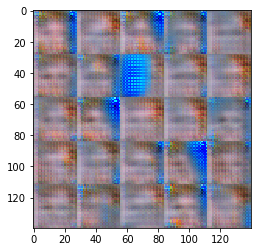

Epoch 1/1... Discriminator Loss: 0.3572... Generator Loss: 7.7135
Epoch 1/1... Discriminator Loss: 0.3588... Generator Loss: 4.7591
Epoch 1/1... Discriminator Loss: 0.3357... Generator Loss: 6.3472
Epoch 1/1... Discriminator Loss: 0.3502... Generator Loss: 5.6104
Epoch 1/1... Discriminator Loss: 0.3846... Generator Loss: 10.2551
Epoch 1/1... Discriminator Loss: 0.3733... Generator Loss: 4.2067
Epoch 1/1... Discriminator Loss: 0.3401... Generator Loss: 6.5384
Epoch 1/1... Discriminator Loss: 0.3704... Generator Loss: 5.9295


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.